<a href="https://colab.research.google.com/github/dainesjeff/AnnotatedTrnsfmr/blob/main/TheAnnotatedAnnotatedTransoformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transformers: the Big Picture**



*  A transformer is a network that creates word embeddings and then uses a
pair of matrices (the Key and Query Matrices) to performer a linear *Transformation* on these embedding vectors in order to optimize computing similarity between vectors using scaled dot-products.

*   Once the Key and Query matrices are used to compute the similarity between the input embedding and all the other embeddings in the vocabulary. A Value matrix *Transformers* the similarity vector into a vector optimized for computing the next word in the sequence via the same scaled dot-product mechanism.

*   The model applies residual connections between layers to implement a "memory" mechanism to take into account the context of the embeddings in their history.
*   Finally, masking is applied to ensure that the model is not using context from its own understanding of future embeddings in a sequence.


*   Multi-Head Attention uses stacks of the K,Q, and V matrices and then concatenates the Value matrices to produces one Hhigh dimensional value matrix. An additional dimensionality-reduction matrix *Transformation* is applied to the high-dimensional value space.
*   List item






# **Installs and Convenience Methods**

In [1]:
!pip install torchtext
!pip install spacy
!pip install portalocker
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

2023-12-15 19:00:04.265875: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-15 19:00:04.265944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-15 19:00:04.267380: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-15 19:00:04.275652: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 19:00:05.471550: W tensorflow/compiler/tf2

In [2]:


### Conveinience Methods
RUN_EXAMPLES = True

def is_interactive_notebook():
    return __name__ == "__main__"


def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)

# **The Model Architecture**



**the top level module that encapsulates the broader encoder/decoder framework.**

In [3]:
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad

class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

**Fully Connected + Softmax Layer**

In [4]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

Because the Ecoder and Decoder consist of N identical layers this method creates copy of modules:

In [5]:
import copy


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


# **Encoder**

**Encoder Module**

The encoder layer is a stack of N (in this case 6) Encoder Layer Modules.


In [6]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

Layer Normalization maintains the mean activation within each example close to 0 and the activation standard deviation close to 1.

Layer Normalization is applied on a per sample frequency as opposed to Batch Normalization which is applied per batch.

In [7]:

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

This sublayer connection module applies a ResNet style residual connection between the current and previous layers.

Additionally, dropout is applied to each connection to prevent overfitting.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of 512 dimensions.

In [8]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

In [9]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

# **Decoder**

The decoder layeris very similar to the encoder layer with the addition of two modules:


1.   A masking module that prevents the model's self-attention mechanism from cheating. This is done by masking future positions (setting them to -0) before the softmax step in the self-attention calculation.

2.   An additional Attention module(Encoder/Decoder Attention) where the output of the top encoder is then transformed into a set of attention vectors K and V. These are to be used by each decoder in its “encoder-decoder attention” layer which helps the decoder focus on appropriate places in the input sequence.



In [10]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

In [11]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

#**Attention**

This Transformer implements Scaled Dot-Product Attention.

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call our particular attention “Scaled Dot-Product Attention”. The input consists of vectors of queries and keys​, and values​ (For paralelization purposes these vectors are stacked into matrices, but the math still works out as long as the deminsions make sense). We compute the dot products of the query with all keys, divide each by the dimentsion of the key vector​, and apply a softmax function (with the number of classes equal to the dimension of the values vector). While the Query and Key Matrices are high dimensional, the value matrix reduces the dimensions (in our case from 512 to 64).




In [12]:
import math

def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

**MultiHead Attention**

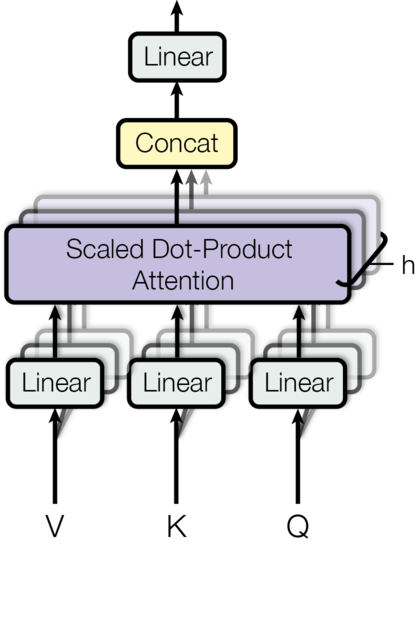

In [13]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

# **Embeddings**

In [14]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)



# **Positional Encoding**

In short, Positional Encoding applies a function (in this case either a sine or cosine depending on the dimension of the embedding vector that is being encoded) that is dependent on both the position of the embedding in the input sentence as well as the deminsion of the embedding vector being encoded.

note: the registerr bugger code at the bottom of the initializer lets torch know not to perform backprop and gradient descent on this module but rather to treeat it as a "static' function.

In [15]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        # Apply sin to even dimensions
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cos to odd ones
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

The illustration below shows how this function performs a consistent transformation based on the position and dimension of a value in an embedding sequence. *Encoding* the *Position* of he value, hence the name.

In [20]:
def example_positional():
    pe = PositionalEncoding(20, 0)
    y = pe.forward(torch.zeros(1, 100, 20))

    data = pd.concat(
        [
            pd.DataFrame(
                {
                    "embedding": y[0, :, dim],
                    "dimension": dim,
                    "position": list(range(100)),
                }
            )
            for dim in [4, 5, 6, 7]
        ]
    )

    return (
        alt.Chart(data)
        .mark_line()
        .properties(width=800)
        .encode(x="position", y="embedding", color="dimension:N")
        .interactive()
    )


show_example(example_positional)

alt.Chart(...)

# **Positionwise Feed-Forward Layer**

In addition to attention sub-layers, each of the layers in our encoder and decoder contains a fully connected feed-forward network, which is applied to each position separately and identically. This consists of two linear transformations with a ReLU activation in between.

In [21]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

# **Masking**

In [18]:
import pandas as pd
import altair as alt

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [19]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)

# **The Complete Transformer Model**

This sets up the complete untrained model and initializes all of the weights randomly.

In [22]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

Perform a pseudo-inference using an untrained model and a pre-determined sequence length.

In [23]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[ 0, 10,  2,  2,  2,  2,  2,  2,  2,  2]])
Example Untrained Model Prediction: tensor([[0, 2, 3, 2, 3, 2, 4, 1, 4, 1]])
Example Untrained Model Prediction: tensor([[0, 8, 1, 8, 1, 8, 8, 8, 8, 8]])
Example Untrained Model Prediction: tensor([[0, 7, 3, 3, 3, 3, 3, 3, 3, 3]])
Example Untrained Model Prediction: tensor([[0, 8, 7, 2, 5, 4, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 9, 3, 9, 3, 9, 3, 9, 3, 9]])
Example Untrained Model Prediction: tensor([[0, 3, 6, 3, 6, 3, 6, 3, 6, 3]])
Example Untrained Model Prediction: tensor([[0, 7, 1, 5, 4, 6, 3, 4, 6, 3]])
Example Untrained Model Prediction: tensor([[0, 8, 1, 2, 2, 2, 2, 2, 2, 2]])
Example Untrained Model Prediction: tensor([[0, 3, 4, 3, 2, 2, 2, 2, 2, 2]])


# **Building Training Data Batches**

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

# **The Training Process**

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
import time

def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    for i, batch in enumerate(data_iter):
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state

# **Preparing the Data**


In [ ]:
import torch
import torchtext
import spacy
import os

def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en


In [ ]:
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets


def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])


def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    # "<s>" SOS token
    # "</s>" EOS token
    # "<blank>" blank space token
    # "<unk>" unknown word token
    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))

    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")

    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


**Load and Tokenize Multi30k (German/English) Dataset**

In [ ]:


def load_vocab(spacy_de, spacy_en):
    if not os.path.exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt


if is_interactive_notebook():
    #global variables used later in the script
    spacy_de, spacy_en = show_example(load_tokenizers)
    vocab_src, vocab_tgt = show_example(load_vocab, args=[spacy_de, spacy_en])

Finished.
Vocabulary sizes:
3712
3430
